#閾値を自動で設定する．

In [95]:
#LightGBM
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# CSVファイルのパス
mse_csv = "/home/data/0203_energee_after/keijo_mse.csv"
size_csv = "/home/data/0203_energee_after/size_pixelcounts.csv"
r_csv = "/home/data/0203_energee_after/R_values.csv"

# CSVを読み込む（filename をインデックスにする）
msedf = pd.read_csv(mse_csv, index_col="filename")  # filename, MSE, class
sizedf = pd.read_csv(size_csv, index_col="filename")  # filename, size_count, class
rdf = pd.read_csv(r_csv, index_col="filename")  # filename, R, class

# `folder` カラムを削除
msedf = msedf.drop(columns=['folder'])
sizedf = sizedf.drop(columns=['folder'])


# `filename` をキーとして結合
df_join = msedf.join(sizedf).join(rdf)

# 'folder' を 'Label' に変更
df_join['Label'] = df_join['folder'].apply(lambda x: 0 if x == 'A' else (1 if x == 'B' else 2))

# 'folder' カラムを削除
df_join = df_join.drop(columns=['folder'])
# 結果を表示
print(df_join.head())

# CSVとして保存
output_csv = "/home/data/0203_energee_after/merged_data.csv"
df_join.to_csv(output_csv)


                       MSE  size_count         R  Label
filename                                               
IMG_1875.JPEG  1620.546875    156181.0  0.029932      0
IMG_1832.JPEG   846.630342    165731.0  0.022063      0
IMG_1881.JPEG  1826.250000    217898.0  0.033801      0
IMG_1865.JPEG  2021.876611    221644.0  0.027558      0
IMG_1919.JPEG   760.463415    137450.0  0.017892      0


In [104]:
import lightgbm as lgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score

# 特徴量（X）とターゲット変数（y）を指定
X = df_join[['MSE', 'size_count', 'R']]  # 特徴量
y = df_join['Label']  # ターゲット変数

# 学習データとテストデータに分割
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# LightGBM データセットに変換
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)  # reference=train_data を追加

# 学習用パラメータ
params = {
    'objective': 'multiclass',  # 分類問題の場合
    'num_class': 3,             # クラス数（'A', 'B', 'C' の3クラス）
    'metric': 'multi_logloss',  # 評価指標
    'boosting_type': 'gbdt',    # 勾配ブースティング
    'num_leaves': 31,           # 最大葉の数
    'learning_rate': 0.05,      # 学習率
    'feature_fraction': 0.9     # 特徴量のサンプリング率
}

# モデル学習
bst = lgb.train(
    params,
    train_data,
    num_boost_round=100,
    valid_sets=[valid_data],  # 先に valid_sets を指定
    # early_stopping_rounds=10  # これを後にする
)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 96
[LightGBM] [Info] Number of data points in the train set: 92, number of used features: 3
[LightGBM] [Info] Start training from score -0.938270
[LightGBM] [Info] Start training from score -1.263692
[LightGBM] [Info] Start training from score -1.120591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

In [105]:
# 予測
y_pred = bst.predict(X_valid, num_iteration=bst.best_iteration)

# 予測値（確率）をクラスラベルに変換
y_pred_class = [np.argmax(x) for x in y_pred]

# 精度を評価
accuracy = accuracy_score(y_valid, y_pred_class)
print(f'Accuracy: {accuracy}')



Accuracy: 0.7083333333333334


In [106]:
# 混同行列やその他の評価指標を表示
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_valid, y_pred_class))
print(classification_report(y_valid, y_pred_class))

[[8 2 2]
 [0 3 1]
 [0 2 6]]
              precision    recall  f1-score   support

           0       1.00      0.67      0.80        12
           1       0.43      0.75      0.55         4
           2       0.67      0.75      0.71         8

    accuracy                           0.71        24
   macro avg       0.70      0.72      0.68        24
weighted avg       0.79      0.71      0.73        24



Accuracy: 0.8333
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.62      0.83      0.71         6
           2       0.88      0.88      0.88         8

    accuracy                           0.83        24
   macro avg       0.83      0.84      0.83        24
weighted avg       0.86      0.83      0.84        24



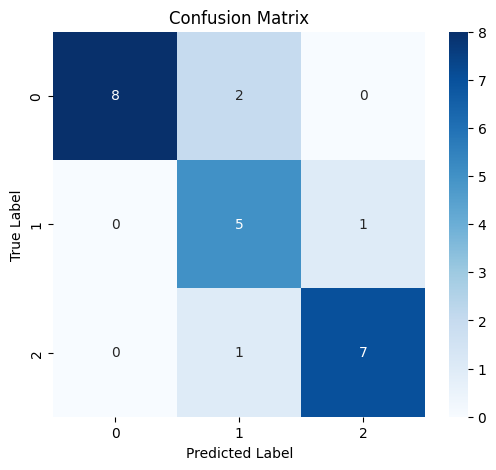

In [108]:
#SVM
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

# === 1. データの読み込み ===
merged_data_csv = "/home/data/0203_energee_after/merged_data.csv"
df = pd.read_csv(merged_data_csv)
# === 2. 特徴量とターゲット変数の定義 ===
X = df[["MSE", "size_count", "R"]]  # 特徴量
y = df["Label"]  # 目的変数

# === 3. 訓練データとテストデータに分割 ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# === 4. 特徴量の標準化 ===
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# === 5. SVMの学習 (RBFカーネル) ===
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', decision_function_shape='ovr')
svm_model.fit(X_train, y_train)

# === 6. 予測と評価 ===
y_pred = svm_model.predict(X_test)

# 精度の表示
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# クラス分類の詳細なレポート
print("Classification Report:\n", classification_report(y_test, y_pred))

# === 7. 混同行列の可視化 ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


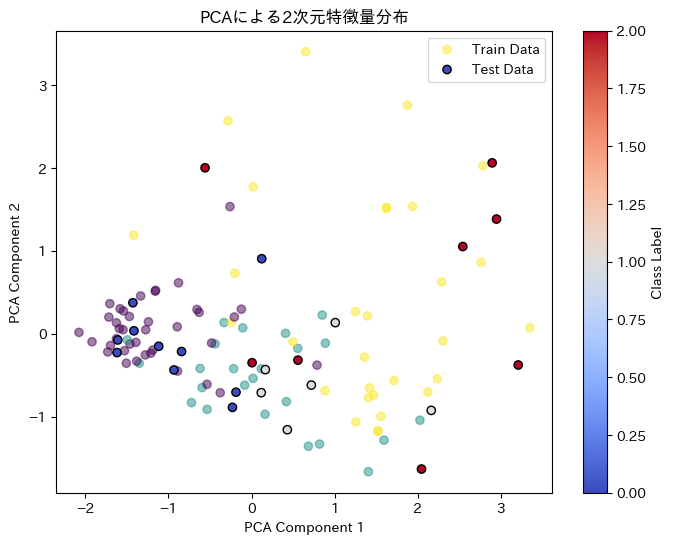

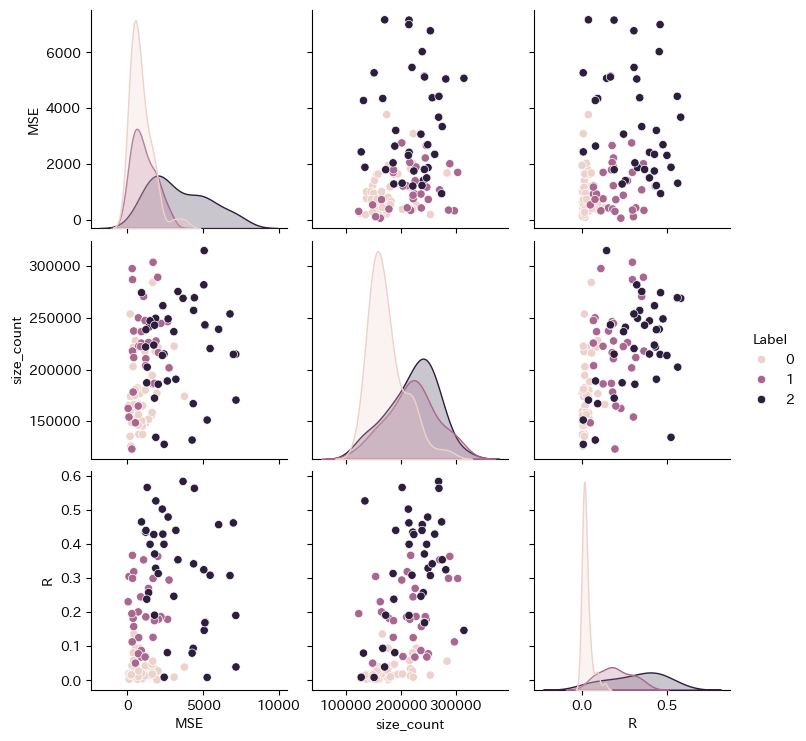

/tmp/ipykernel_2658763/3378935672.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importance, palette="coolwarm")


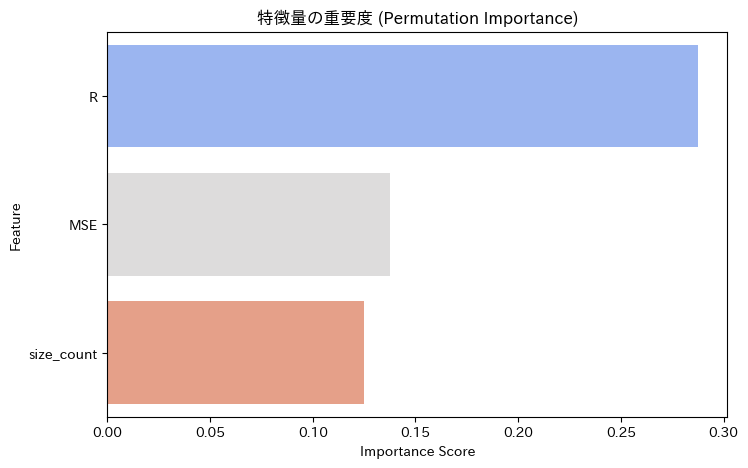

In [110]:
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
import japanize_matplotlib

# === 1. PCAを使った2Dプロット ===
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap="viridis", alpha=0.5, label="Train Data")
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap="coolwarm", edgecolors="k", label="Test Data")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCAによる2次元特徴量分布")
plt.legend()
plt.colorbar(label="Class Label")
plt.show()

# === 2. 特徴量のペアプロット ===
sns.pairplot(df, hue="Label", diag_kind="kde")
plt.show()

# === 3. 特徴量の重要度 (Permutation Importance) ===
perm_importance = permutation_importance(svm_model, X_test, y_test, scoring="accuracy", n_repeats=10, random_state=42)
feature_importance = pd.DataFrame({"Feature": X.columns, "Importance": perm_importance.importances_mean})
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x="Importance", y="Feature", data=feature_importance, palette="coolwarm")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("特徴量の重要度 (Permutation Importance)")
plt.show()


In [68]:
#形状
import os 
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import scipy.stats as stats
import seaborn as sns
import pandas as pd
from sklearn.metrics import roc_curve


data = "0203_energee_after"
outputfile = f"/home/data/{data}/keijo_mse.csv"
inputfolder_lists = [
    f"/home/data/{data}/maskBB/A",
    f"/home/data/{data}/maskBB/B",
    f"/home/data/{data}/maskBB/C",
]
one_dimensional_data_dict = {}
evaluation_results = {}

for folder in inputfolder_lists:
    folder_name = os.path.basename(folder)
    image_paths = glob.glob(os.path.join(folder, '*.JPEG'))
    
    # 画像ファイル数をカウント
    num_images = len(image_paths)
    print(f"Folder {folder_name} contains {num_images} images.")

    for img_path in image_paths:
        # 画像の読み込み
        mask = cv2.imread(img_path)

        # グレースケール画像に変換
        gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

        # 二値化
        _, th = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # 輪郭を検出し、最大の輪郭を取得
        contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            continue
        max_contour = max(contours, key=cv2.contourArea)

        # 最小外接円を取得
        (x, y), radius = cv2.minEnclosingCircle(max_contour)
        radius = int(radius)

        # 重心を計算
        M = cv2.moments(max_contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
            cX, cY = 0, 0
        center = (cX, cY)

        # 極座標変換
        h, w = gray.shape
        flags = cv2.INTER_CUBIC + cv2.WARP_FILL_OUTLIERS + cv2.WARP_POLAR_LINEAR
        linear_polar = cv2.warpPolar(gray, (w, h), center, radius, flags)

        # 行ごとの黒ピクセル数をカウント
        black_pixel_count = np.sum(linear_polar == 0, axis=1)
        file_name = os.path.basename(img_path)
        one_dimensional_data_dict[file_name] = black_pixel_count

        # 真円の場合の理想データ（黒ピクセル数が0）
        y_pseudo = np.zeros_like(black_pixel_count)

        # 評価指標の計算
        mae = mean_absolute_error(y_pseudo, black_pixel_count)
        mse = mean_squared_error(y_pseudo, black_pixel_count)
        rmse = np.sqrt(mse)  # RMSEを計算

        evaluation_results[file_name] = {
            'MSE': mse, 
            # 'MAE': mae, 
            # 'RMSE': rmse,  # RMSEを追加
            'Folder': folder_name
        }

# MAE、MSE、RMSEの抽出
file_names = list(evaluation_results.keys())
# mae_values = [metrics['MAE'] for metrics in evaluation_results.values()]
mse_values = [metrics['MSE'] for metrics in evaluation_results.values()]
# rmse_values = [metrics['RMSE'] for metrics in evaluation_results.values()]
folders = [metrics['Folder'] for metrics in evaluation_results.values()]
# DataFrame に変換
df = pd.DataFrame(evaluation_results).T  # .T で転置して見やすくする
df.reset_index(inplace=True)
df.rename(columns={'index': 'filename'}, inplace=True)
df.rename(columns={'Folder': 'folder'}, inplace=True)
df['filename'] = df['filename'].astype(str)  # filenameを文字列型に
df['MSE'] = df['MSE'].astype(float)  # MSEを浮動小数型に
df['folder'] = df['folder'].astype(str)  # folderを文字列型に

# CSVとして保存
df.to_csv(outputfile, index=False)

df = pd.DataFrame({
    'File': file_names,
    'MSE': mse_values,
    'Folder': folders
})

# フォルダーを二値ラベルに変換
df['Label'] = df['Folder'].apply(lambda x: 1 if x == 'C' else 0)  # 'C' は異常 (1), 'A' or 'B' は正常 (0)

# MSEの分布を可視化
# plt.figure(figsize=(8, 5))
# sns.histplot(df, x='MSE', hue='Folder', kde=True, bins=30)
# plt.axvline(df[df['Label'] == 0]['MSE'].max(), color='red', linestyle='dashed', label="Max Normal MSE")
# plt.legend()
# plt.title("MSE Distribution by Folder")
# plt.show()

Folder A contains 48 images.
Folder B contains 30 images.
Folder C contains 38 images.


In [30]:
# fpr, tpr, thresholds = roc_curve(df['Label'], df['MSE'])

# # Youden’s Indexを最大化する閾値
# youden_index = tpr - fpr
# keijo_threshold = thresholds[np.argmax(youden_index)]
# print(f"Optimal Threshold from ROC: {keijo_threshold}")

# # ROC曲線のプロット
# plt.plot(fpr, tpr, label="ROC Curve")
# plt.scatter(fpr[np.argmax(youden_index)], tpr[np.argmax(youden_index)], color="red", label="Optimal Threshold")
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.legend()
# plt.title("ROC Curve and Optimal Threshold")
# plt.show()


In [86]:
import os 
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import scipy.stats as stats
import seaborn as sns
import pandas as pd
from sklearn.metrics import roc_curve

# データフォルダの設定
date = "0203_energee_after"
output_file = f"/home/data/{date}/size_pixelcounts.csv"
input_folders = [
    f"/home/data/{date}/maskBB/A",
    f"/home/data/{date}/maskBB/B",
    f"/home/data/{date}/maskBB/C",
]
# フォルダごとのラベル設定
labels = ['Folder A', 'Folder B', 'Folder C']

# 結果を保存するリスト
data_list = []

# データの収集
for input_folder, label in zip(input_folders, labels):
    for file in os.listdir(input_folder):
        if file.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.JPEG')):
            file_path = os.path.join(input_folder, file)
            image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

            # 二値化
            _, image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)

            # 白ピクセルのカウント
            white_pixel_count = np.sum(image == 255)

            # ファイル名（拡張子を除去）
            # filename = os.path.splitext(file)[0]
            filename = file

            # データをリストに追加
            data_list.append([filename, white_pixel_count, label])

# データフレームを作成
df = pd.DataFrame(data_list, columns=["filename", "size_count", "folder"])
df['folder'] = df['folder'].str.replace('Folder ', '')
df['filename'] = df['filename'].astype(str)  # filenameを文字列型に
df['size_count'] = df['size_count'].astype(float)  # size_countを浮動小数型に
df['folder'] = df['folder'].astype(str)  # folderを文字列型に

# CSVに保存
df.to_csv(output_file, index=False)

# フォルダーを二値ラベルに変換
df['Label'] = df['folder'].apply(lambda x: 1 if x == 'C' else 0)  # 'C' は異常 (1), 'A' or 'B' は正常 (0)

# MSEの分布を可視化
# plt.figure(figsize=(8, 5))
# sns.histplot(df, x='size_count', hue='folder', kde=True, bins=30)
# plt.axvline(df[df['Label'] == 0]['size_count'].max(), color='red', linestyle='dashed', label="Max Normal value")
# plt.legend()
# plt.title("value Distribution by Folder")
# plt.show()

In [28]:
# fpr, tpr, thresholds = roc_curve(df['Label'], df['value'])

# # Youden’s Indexを最大化する閾値
# youden_index = tpr - fpr
# size_threshold = thresholds[np.argmax(youden_index)]
# print(f"Optimal Threshold from ROC: {size_threshold}")

# # ROC曲線のプロット
# plt.plot(fpr, tpr, label="ROC Curve")
# plt.scatter(fpr[np.argmax(youden_index)], tpr[np.argmax(youden_index)], color="red", label="Optimal Threshold")
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.legend()
# plt.title("ROC Curve and Optimal Threshold")
# plt.show()
# print(f"Optimal Threshold from ROC: {size_threshold}")

In [74]:
#襞領域
import os
import re
import cv2
import numpy as np
import math
from PIL import Image
import matplotlib.pyplot as plt
from icecream import ic
import pandas as pd

# fmxy (7)
def fmxy(absfxy, mxy):
    return np.where(absfxy > mxy, 1, 0)

def Min(a, b):
    return np.minimum(a, b)

def G12(theta1, theta2):
    condition1 = (theta2 - np.pi < theta1) & (theta1 < theta2) & (theta2 >= 0)
    result1 = np.abs(theta1 - theta2)
    condition2 = (-np.pi < theta1) & (theta1 < (theta2 - np.pi)) & (theta2 >= 0)
    result2 = theta2 - 2 * np.pi - theta1
    condition3 = (-np.pi < theta1) & (theta1 < (theta2 + np.pi)) & (theta2 < 0)
    result3 = np.abs(theta1 - theta2)
    condition4 = (theta2 + np.pi < theta1) & (theta1 < np.pi) & (theta2 < 0)
    result4 = theta1 - theta2 - 2 * np.pi
    result = np.where(condition1, result1, 
             np.where(condition2, result2, 
             np.where(condition3, result3, 
             np.where(condition4, result4, 0))))
    return result

# 平方面積の合計 (11)(12) Tr Tm
def SquareSum(I, x, y, h, w, n):
    x1, y1 = x - n, y - n
    x2, y2 = x + n, y + n
    x1, x2 = max(x1, 0), min(x2, w - 2)
    y1, y2 = max(y1, 0), min(y2, h - 2)
    total = I[y2, x2] - I[y1, x2] - I[y2, x1] + I[y1, x1]
    return total

# sdis = Tr/Tm (13)
def sdis(Iruv, Imyv, x, y, h, w, n):
    Tr = SquareSum(Iruv, x, y, h, w, n)
    Tm = SquareSum(Imyv, x, y, h, w, n)
    return Tr / Tm

# パラメータ
n = 15
date = "0203_energee_after"
data_list = []

img_folders = [
    f"/home/data/{date}/maskedBB/A",
    f"/home/data/{date}/maskedBB/B",
    f"/home/data/{date}/maskedBB/C",
]
mask_folders = [
    f"/home/data/{date}/maskBB/A",
    f"/home/data/{date}/maskBB/B",
    f"/home/data/{date}/maskBB/C",
]

for img_folder, mask_folder in zip(img_folders, mask_folders):
    folder_name = os.path.basename(img_folder)
    img_files = os.listdir(img_folder)
    mask_files = os.listdir(mask_folder)
    
    for img_file, mask_file in zip(img_files, mask_files):
        img_path = os.path.join(img_folder, img_file)
        mask_path = os.path.join(mask_folder, mask_file)
        
        # 重心 (1)
        img = cv2.imread(img_path)
        mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        masked_img = cv2.imread(img_path)
        h, w = img.shape[:2]
        
        # 重心を計算
        x_sum, y_sum, count = 0, 0, 0
        for i in range(h):
            for j in range(w):
                if mask_img[i][j] == 255:
                    x_sum += j
                    y_sum += i
                    count += 1
        xc, yc = (x_sum / count, y_sum / count) if count > 0 else (0, 0)
        
        # fθ(x,y)(勾配の方向), |f(x,y)| (2)(3)
        image = cv2.cvtColor(masked_img, cv2.COLOR_BGR2GRAY)
        fdy, fdx = np.gradient(image)
        f0xy = np.arctan2(fdy, fdx)
        absfxy = np.uint8(np.sqrt(fdx**2 + fdy**2))
        
        # C0(x,y)：中心からのベクトルの角度
        height, width = image.shape
        C0xy = np.zeros((height, width))
        for y in range(height):
            for x in range(width):
                dx, dy = x - xc, y - yc
                C0xy[y, x] = np.arctan(dy / dx) if dx != 0 else 0
        
        # f(xy)の勾配ベクトルが中心から(x,y)へのベクトルへ垂直か評価する関数fdisxy(4)(5)
        fdisxy = Min(G12(C0xy + np.pi/2, f0xy)**2, G12(C0xy - np.pi/2, f0xy)**2)
        
        # mxy = |fxy|に対する2n+1×2n+1のメディアンフィルタリングの結果
        kernel_size = 2 * n + 1
        mxy = np.uint8(cv2.medianBlur(absfxy, kernel_size))
        
        # rdis (8)
        rdisxy = fmxy(absfxy, mxy) * fdisxy
        
        # Iruv, Imyv (9)(10)
        Iruv = cv2.integral(rdisxy)
        Imyv = cv2.integral(fmxy(absfxy, mxy).astype(np.uint8))
        
        # sdis計算
        sdisval = np.zeros((image.shape[0], image.shape[1]))
        for y in range(0, image.shape[0], 1):
            for x in range(0, image.shape[1], 1):
                sdisval[y, x] = sdis(Iruv, Imyv, x, y, h, w, n)
        sdisval = np.nan_to_num(sdisval, nan=0.0, posinf=0.0, neginf=0.0)
        
        # 閾値処理
        T = 0.2
        hxy = np.where(sdisval < T, 1, 0)
        hxy2 = cv2.bitwise_and(hxy, hxy, mask=mask_img)
        
        # シイタケ領域のPixel数を計算
        count_mask = np.sum(mask_img == 255)
        count_hida = np.sum(hxy2 == 1)
        R = count_hida / count_mask if count_mask > 0 else 0
        data_list.append((img_file, R,folder_name))
        



/tmp/ipykernel_2658763/1908198874.py:47: RuntimeWarning: invalid value encountered in scalar divide
  return Tr / Tm
/tmp/ipykernel_2658763/1908198874.py:47: RuntimeWarning: divide by zero encountered in scalar divide
  return Tr / Tm


In [75]:
output_csv = f"/home/data/{date}/R_values.csv"
df = pd.DataFrame(data_list, columns=["filename", "R","folder"])
df['filename'] = df['filename'].astype(str)  # filenameを文字列型に
df['R'] = df['R'].astype(float)  # Rを浮動小数型に
df['folder'] = df['folder'].astype(str)  # folderを文字列型に
df.to_csv(output_csv, index=False)